## Data Analysis Task

- **Applicant:** Xabi Moreno
- **Position:** Data Analyst for Schibsted Spain
- **Date:** Marth 24, 2019

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import csv

I decided to make a new .csv file instead of altering the original one because I wanted the former to remain untouched. I will use Unix timestamp to calculate `session_length`.

In [2]:
with open('events_log.csv','r') as csvinput, open('events_log_2.csv', 'w') as csvoutput:
        writer = csv.writer(csvoutput, lineterminator='\n')
        reader = csv.reader(csvinput)

        all = []
        row = next(reader)
        row.append('unix_timestamp')
        all.append(row)

        for row in reader:
            uts = str(int(float(row[1])))
            uts = time.mktime(datetime.datetime.strptime(uts, "%Y%m%d%H%M%S").timetuple())
            row.append(uts)
            all.append(row)

        writer.writerows(all)

### 1. What is our daily overall clickthrough rate?

In [3]:
df = pd.read_csv('events_log_2.csv')
df['day'] = (df['timestamp'] // 1000000).astype('int64')

d_ctr = pd.pivot_table(df, 
                       values='uuid', 
                       index=['day'], 
                       columns=['action'], 
                       aggfunc=lambda x: len(x.unique()))

d_ctr['av_ctr'] = round(d_ctr.visitPage / d_ctr.searchResultPage, 2)
d_ctr[['searchResultPage', 'visitPage', 'av_ctr']]

action,searchResultPage,visitPage,av_ctr
day,,,
20160301,18374,6654,0.36
20160302,18902,6692,0.35
20160303,19159,6574,0.34
20160304,16675,4294,0.26
20160305,13204,3323,0.25
20160306,14612,3758,0.26
20160307,19011,4714,0.25
20160308,16297,4098,0.25


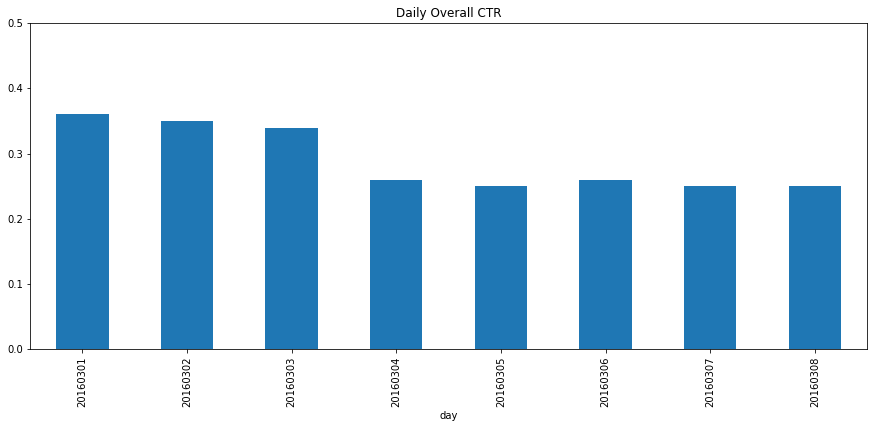

In [4]:
d_ctr['av_ctr'].plot.bar(title='Daily Overall CTR', use_index=True, figsize=(15,6), ylim=[0,0.5])

### 1.1. How does it vary between the groups?

In [5]:
ga_ctr = pd.pivot_table(df[df.group == 'a'], 
                        values='uuid', 
                        index=['day'], 
                        columns=['action'], 
                        aggfunc=lambda x: len(x.unique()))

gb_ctr = pd.pivot_table(df[df.group == 'b'], 
                        values='uuid', 
                        index=['day'], 
                        columns=['action'], 
                        aggfunc=lambda x: len(x.unique()))

ga_ctr['av_ctr'] = round(ga_ctr['visitPage']/ga_ctr['searchResultPage'], 2)
gb_ctr['av_ctr'] = round(gb_ctr['visitPage']/gb_ctr['searchResultPage'], 2)

g_ctr = pd.merge(ga_ctr['av_ctr'], gb_ctr['av_ctr'], on=['day'], suffixes=('_a', '_b'))
g_ctr = g_ctr.merge(d_ctr['av_ctr'], on=['day'])
g_ctr


,av_ctr_a,av_ctr_b,av_ctr
day,,,
20160301,0.47,0.13,0.36
20160302,0.45,0.13,0.35
20160303,0.43,0.14,0.34
20160304,0.30,0.17,0.26
20160305,0.29,0.18,0.25
20160306,0.31,0.17,0.26
20160307,0.28,0.17,0.25
20160308,0.30,0.16,0.25


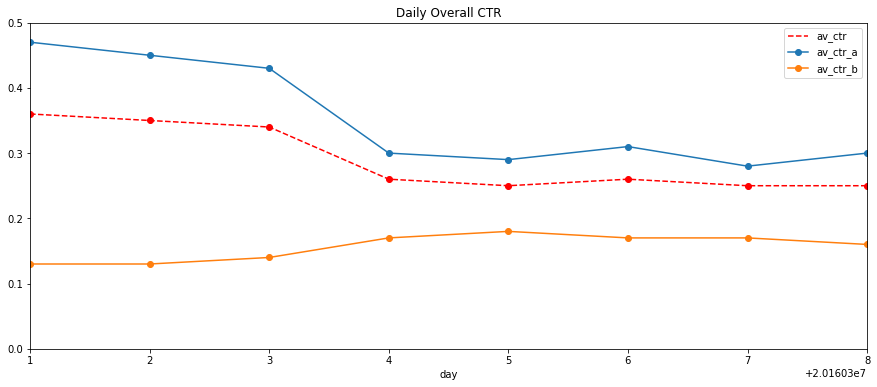

In [6]:
ax = g_ctr[['av_ctr']].plot(linestyle='--', marker='o', color='Red')
g_ctr[['av_ctr_a', 'av_ctr_b']].plot(title='Daily Overall CTR', figsize=(15,6), ylim=[0,0.5], ax=ax, marker='o')

### 2. Which results do people tend to try first? How does it change day-to-day?

In [7]:
clk_res = pd.pivot_table(df, values='result_position', index=['day'], margins=True)
clk_res['result_position'] = round(clk_res['result_position']).astype('int64')
clk_res

,result_position
day,
20160301,5
20160302,2
20160303,3
20160304,4
20160305,2
20160306,2
20160307,3
20160308,3
All,3


### 3. What is our daily overall zero results rate? How does it vary between the groups?

In [8]:
df['n_results'].fillna(0, inplace=True)
df['n_results'] = df['n_results'].astype('int64')

n_results_na = pd.pivot_table(df[df.n_results == 0],
                              values='n_results', 
                              index=['day'], 
                              columns=['action'], 
                              aggfunc='count')

n_results_na_a = pd.pivot_table(df[(df.n_results == 0) & (df.group == 'a')],
                                values='n_results', 
                                index=['day'], 
                                columns=['action'], 
                                aggfunc='count')

n_results_na_b = pd.pivot_table(df[(df.n_results == 0) & (df.group == 'b')],
                                values='n_results', 
                                index=['day'], 
                                columns=['action'], 
                                aggfunc='count')

zr_rate = pd.merge(d_ctr['searchResultPage'], n_results_na['searchResultPage'], on=['day'], suffixes=('_all', '_na'))
zr_rate_g = pd.merge(ga_ctr['searchResultPage'], gb_ctr['searchResultPage'], on=['day'], suffixes=('_a', '_b'))
zr_rate_na_g = pd.merge(n_results_na_a['searchResultPage'], n_results_na_b['searchResultPage'], on=['day'], suffixes=('_na_a', '_na_b'))
zr_rate = pd.merge(zr_rate, zr_rate_g, on=['day']).merge(zr_rate_na_g, on=['day'])

zr_rate['zr_rate'] = round(zr_rate['searchResultPage_na']/zr_rate['searchResultPage_all'], 4)
zr_rate['zr_rate_a'] = round(zr_rate['searchResultPage_na_a']/zr_rate['searchResultPage_a'], 4)
zr_rate['zr_rate_b'] = round(zr_rate['searchResultPage_na_b']/zr_rate['searchResultPage_b'], 4)

zr_rate[['zr_rate', 'zr_rate_a', 'zr_rate_b']]

,zr_rate,zr_rate_a,zr_rate_b
day,,,
20160301,0.1876,0.1868,0.1894
20160302,0.1899,0.1911,0.1871
20160303,0.1797,0.1785,0.1823
20160304,0.1808,0.1830,0.1761
20160305,0.1849,0.1782,0.1975
20160306,0.1762,0.1689,0.1896
20160307,0.1820,0.1824,0.1812
20160308,0.1937,0.1961,0.1889


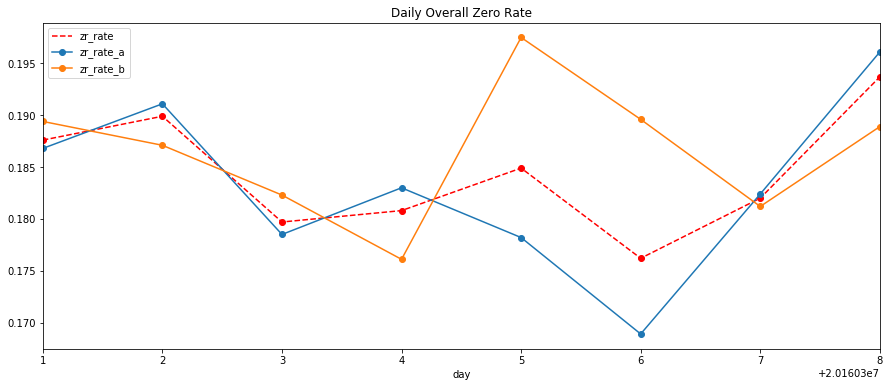

In [9]:
ax2 = zr_rate[['zr_rate']].plot(linestyle='--', marker='o', color='Red')
zr_rate[['zr_rate_a', 'zr_rate_b']].plot(title='Daily Overall Zero Rate', figsize=(15,6), ax=ax2, marker='o')

### 4. Let session length be approximately the time between the first event and the last event in a session. Choose a variable from the dataset and describe its relationship to session length. Visualize the relationship.

The only variable that can be used to calculate session length is 'timestamp'. I decided to add a new column with Unix timestamp because 'timestamp' is a string and pandas' operations with strings are not very efficient. At the same time, Unix timestamp allows me to operate with seconds which is the time unit I need for `sessions_length`.

In [10]:
df['unix_timestamp'] = df['unix_timestamp'].astype('int64')
sessions = df.groupby(['session_id'])
maxvals = sessions.apply(lambda x: x.sort_values('unix_timestamp', ascending = False).head(1))
minvals = sessions.apply(lambda x: x.sort_values('unix_timestamp', ascending = True).head(1))

In [18]:
sessions_merged = pd.merge(minvals, maxvals,  how='outer', left_index=True, right_index=True, suffixes=('_min', '_max'))

sessions_length = pd.pivot_table(sessions_merged,
                                 values=['unix_timestamp_min', 'unix_timestamp_max'],
                                 index=['session_id'],
                                 aggfunc='sum')

sessions_length['session_length'] = (sessions_length['unix_timestamp_max']-sessions_length['unix_timestamp_min']).astype('int64')
sessions_length[['session_length']].mean().astype('int64')

session_length    153
dtype: int64

The average session length in this time frame is **153 seconds**.